In [46]:
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from PIL import ImageEnhance
from PIL import ImageFilter

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
from pathlib import Path

In [47]:
np.random.seed(42)

In [48]:
#Edit this to point to project root
sep = "\\"
home = f"B:{sep}Dev{sep}GitHub{sep}University{sep}MSc Thesis{sep}StolenVehicleDetector{sep}Machine Learning{sep}OCR{sep}"
local_home = f"{home}"

In [49]:
local_data_dir = f"{local_home}data{sep}"

In [50]:
class PlateGeneratorInit:
    '''The plate generator init class
    '''

    dataset_name = "plate_generator"
    source_url: str = ""

    def __init__(self, data_dir: str, sep: str) -> None:
        self.dataset_dir = data_dir + self.dataset_name
        self.sep = sep
        self.characters: set = set()
        self.fonts: set = set()
        self.overlays: set = set()

    def __download_sources(self):
        pass

    def load(self):
        '''Loads the dataset generator sources before working with it
        '''
        # Download dataset generator sources if it has not been yet
        self.__download_sources()

        characters_path = Path(f"{self.dataset_dir}{sep}characters.txt")
        # Set of characters
        characters = set(line.strip() for line in open(characters_path))
        self.characters = sorted(characters)

        fonts_path = Path(f"{self.dataset_dir}{sep}fonts{sep}")
        # Set of fonts
        self.fonts = list(map(str, list(fonts_path.glob("*.ttf"))))

        overlays_path = Path(f"{self.dataset_dir}{sep}overlays{sep}")
        # Set of dusts
        self.overlays = list(map(str, list(overlays_path.glob("*.png"))))

    def prepare(self):
        '''Prepare the whole dataset before working with it
        '''
        pass

    def show_info(self):
        '''Show dataset generator properties
        '''
        print("Number of fonts: ", len(self.fonts))
        print("Number of overlay images: ", len(self.overlays))
        print("Number of unique characters: ", len(self.characters))
        print("Characters present: ", self.characters)

In [51]:
data_loader = PlateGeneratorInit(local_data_dir, sep)
data_loader.load()
data_loader.show_info()

Number of fonts:  17
Number of overlay images:  11
Number of unique characters:  37
Characters present:  ['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [52]:
#Required input image dimensions (N x N images)
img_h = 50
img_w = 500
#3 means RGB, 1 means grayscale
n_channels = 3

In [53]:
# Batch size for training and validation
batch_size = 16

characters = data_loader.characters
# add space for some kind of regularization
#characters.append(' ')

min_len = 1
max_len = 20

font_str_list = data_loader.fonts
font_size = 50
fonts = list(ImageFont.truetype(font_str, font_size) for font_str in font_str_list)

overlay_str_list = data_loader.overlays
overlays = list(Image.open(overlay_str) for overlay_str in overlay_str_list)

In [54]:
def generate_text(min_len, max_len, characters):
    # random length between the specified range
    text_length = np.random.randint(max_len, size=1)
    text_length += min_len
    # random char sequence
    char_seq = np.random.choice(characters, size=text_length)
    # shring to string
    text = ""
    for char in char_seq:
        text += char.upper()
    return text

In [55]:
def generate_overlay(overlays, image_dim):

    overlay_img = random.choice(overlays)

    img_h = image_dim[0]
    img_w = image_dim[1]

    # random image resize
    resize_ratio = random.uniform(0.5, 2)
    new_h = int(img_h*resize_ratio)
    new_w = int(img_w*resize_ratio)
    overlay_img = overlay_img.resize((new_w, new_h))

    # random image rotation
    random_rotation = random.uniform(0, 360)
    overlay_img = overlay_img.rotate(random_rotation, expand=False)

    return overlay_img

In [83]:
def generate_image(text, image_dim, n_channels, font, dust,
    min_background_text_color_diff=50, resize_text=(0.85, 1.01), text_aspect_ratio=(0.75, 1.5), random_offset_needed=True, rotation_deg=(-7, 7),
    random_brightness=(0.7, 1.2), random_contrast=(0.5, 2), random_sharpness=(0.1, 2), random_blur=(0, 1.5), random_resolution=(0.3, 1)):
    ''' With these parameters, the worst scenario is that 1 character is 10 pixel wide. 
        In 100 pixels there are maximum 10 characters -> 20 time steps needed per 100 pixels to detect 10 chars + the empty chars between them.
    '''

    img_type = ""
    background_color = (0)
    text_color = (0)
    # generate random colors
    background_color = np.random.randint(255, size=n_channels)
    color_diff_safe_zone = 2*min_background_text_color_diff
    text_color_offset = np.random.randint(255-color_diff_safe_zone, size=1)[0].item() + min_background_text_color_diff
    text_color = (background_color + text_color_offset) % 255
    # if grayscale image is needed, set grayscale type & colors
    if(n_channels == 1):
        img_type = "L"
        background_color = background_color.item()
        text_color = text_color.item()
    # if RGB image is needed, set RGB type & colors
    elif(n_channels == 3):
        img_type = "RGB"
        background_color = tuple(background_color)
        text_color = tuple(text_color)

    img_h = image_dim[0]
    img_w = image_dim[1]

    bb_dim = font.getbbox(text=text, anchor="la")
    bb_h = bb_dim[3]
    bb_w = bb_dim[2]

    # create background image
    background = Image.new(img_type, (img_w, img_h), background_color)
    # create text image
    text_img = Image.new(img_type, (bb_w, bb_h), background_color)
    draw = ImageDraw.Draw(text_img)
    draw.text((0, 0), text, text_color, anchor="la", font=font)
    draw = ImageDraw.Draw(text_img)

    resize_ratio = 1
    # if text is bigger than background in any dimension, calculate resize_ratio to fit text onto the background
    if((bb_w > img_w) or (bb_h > img_h)):
        req_ratio_w = float(img_w)/float(bb_w)
        req_ratio_h = float(img_h)/float(bb_h)
        resize_ratio = min(req_ratio_w, req_ratio_h)
    # multiply resize_ratio with a value in resize_text range
    resize_ratio *= random.uniform(resize_text[0], resize_text[1])
    # resize text
    new_h = int(bb_h*resize_ratio)
    new_w = int(bb_w*resize_ratio)
    text_img = text_img.resize((new_w, new_h))

    # random text aspect ratio change with a value in text_aspect_ratio range
    aspect_ratio_change_width = random.uniform(text_aspect_ratio[0], text_aspect_ratio[1])
    new_w = min(int(aspect_ratio_change_width*new_w), img_w)
    text_img = text_img.resize((new_w, new_h))

    offset = (0, 0)
    # random offset between the specified range to fit background
    if(random_offset_needed):
        h_offset_max = max(1, img_h-new_h)
        w_offset_max = max(1, img_w-new_w)
        rand_h_offset = np.random.randint(h_offset_max, size=1)[0]
        rand_w_offset = np.random.randint(w_offset_max, size=1)[0]
        offset = (rand_w_offset, rand_h_offset)
    background.paste(text_img, offset)

    # random image rotation
    random_rotation = random.uniform(rotation_deg[0], rotation_deg[1])
    background = background.rotate(random_rotation, expand=True, fillcolor=background_color)
    background = background.resize((img_w, img_h))

    # paste dust image
    dust_offset = (0, 0)
    # random dust offset between the specified range to fit background
    h_dust_offset_max = max(1, img_h-new_h)
    w_dust_offset_max = max(1, img_w-new_w)
    rand_h_dust_offset = np.random.randint(h_dust_offset_max, size=1)[0]
    rand_w_dust_offset = np.random.randint(w_dust_offset_max, size=1)[0]
    dust_offset = (rand_w_dust_offset, rand_h_dust_offset)
    background.paste(dust, dust_offset, dust)

    # random image enhancements
    # brightness
    brightness = random.uniform(random_brightness[0], random_brightness[1])
    background = ImageEnhance.Brightness(background).enhance(brightness)
    # contrast
    contrast = random.uniform(random_contrast[0], random_contrast[1])
    background = ImageEnhance.Contrast(background).enhance(contrast)
    # sharpness
    sharpness = random.uniform(random_sharpness[0], random_sharpness[1])
    background = ImageEnhance.Sharpness(background).enhance(sharpness)
    
    # random gaussian blur
    blur = random.uniform(random_blur[0], random_blur[1])
    background = background.filter(ImageFilter.GaussianBlur(blur))

    # random resolution: downscale image
    resolution = random.uniform(random_resolution[0], random_resolution[1])
    resolution_h = int(img_h * resolution)
    resolution_w = int(img_w * resolution)
    background = background.resize((resolution_w, resolution_h))
    # upscale the image to output required dimensions
    background = background.resize((img_w, img_h))

    return background

In [84]:
def show_image(img):
    image = np.array(img, dtype=float)
    # normalize from [0..255] to [0..1]
    image *= (1/255.0)
    # image to tensor
    image = tf.keras.preprocessing.image.img_to_array(image)
    print(image.shape)

    # if image has only one channel, drop channel dim to plot with matplotlib
    if(image.shape[2] == 1):
        image = image[:,:,0]
    imgplot = plt.imshow(image)
    plt.show()

(50, 500, 3)


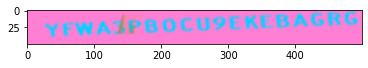

In [85]:
text = generate_text(min_len, max_len, characters)
font = random.choice(fonts)
overlay = generate_overlay(overlays, (img_h, img_w))
image = generate_image(text, (img_h, img_w), n_channels, font, overlay)
show_image(image)

(50, 500, 3)


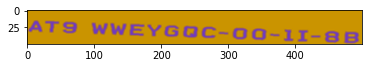

(50, 500, 3)


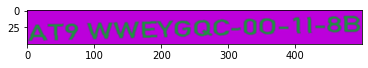

(50, 500, 3)


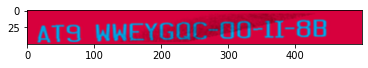

(50, 500, 3)


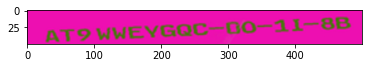

(50, 500, 3)


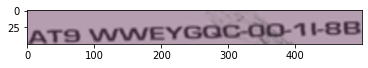

(50, 500, 3)


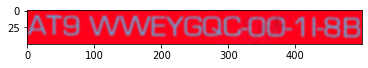

(50, 500, 3)


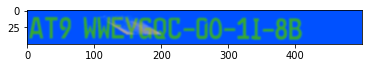

(50, 500, 3)


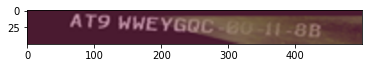

(50, 500, 3)


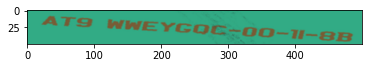

(50, 500, 3)


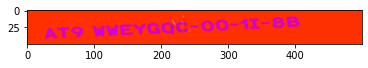

(50, 500, 3)


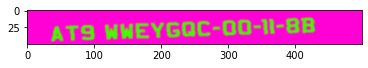

(50, 500, 3)


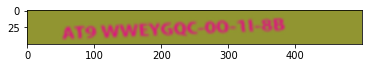

(50, 500, 3)


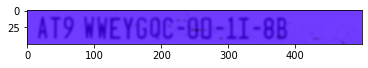

(50, 500, 3)


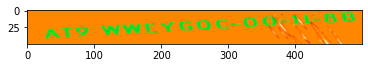

(50, 500, 3)


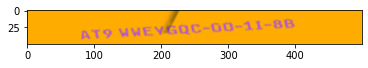

(50, 500, 3)


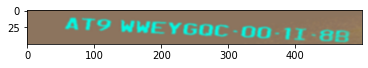

(50, 500, 3)


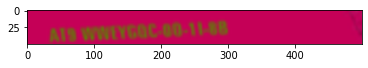

In [86]:
text = "at9 wweygqc-0O-1I-8b".upper()

for font in fonts:
    overlay = generate_overlay(overlays, (img_h, img_w))
    img = generate_image(text, (img_h, img_w), n_channels, font, overlay)
    show_image(img)

In [87]:
def generate_data():
    text = generate_text(1, 20, characters)
    font = random.choice(fonts)
    overlay = generate_overlay(overlays, (img_h, img_w))
    image = generate_image(text, (img_h, img_w), n_channels, font, overlay)
    return image, text

W5Q
(50, 500, 3)


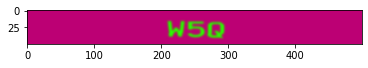

X9X6534XS9PJC
(50, 500, 3)


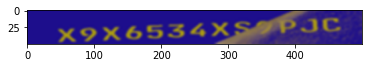

IIOJLAB85Z
(50, 500, 3)


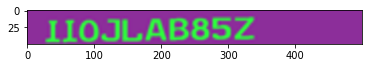

67I9K
(50, 500, 3)


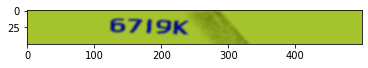

1FC84TT7AO02UQ4SQBY
(50, 500, 3)


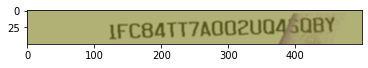

0C816F2JSHDIS8
(50, 500, 3)


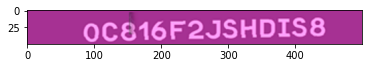

T6DKU37D
(50, 500, 3)


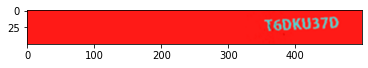

94F37RLYTIL5Y2MCN5D
(50, 500, 3)


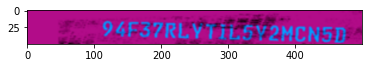

D
(50, 500, 3)


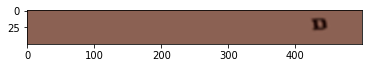

7QX19ILSZYAYXW2MYQ03
(50, 500, 3)


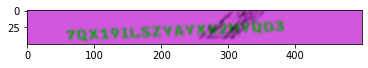

QGWJ-LWY76SYYG09YT
(50, 500, 3)


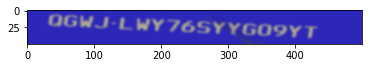

-
(50, 500, 3)


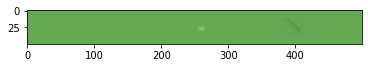

Y9O0RRYH895B0SK-P5-
(50, 500, 3)


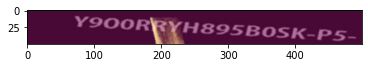

OREH-ZWR
(50, 500, 3)


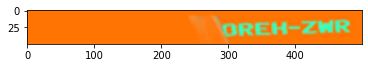

C61XPWQTFH
(50, 500, 3)


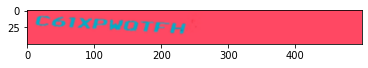

FY
(50, 500, 3)


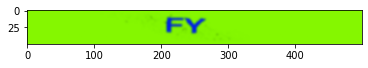

In [90]:
for i in range(batch_size):
    image, text = generate_data()
    print(text)
    show_image(image)

In [91]:
import timeit
num_iters = 1000

avg = (timeit.timeit(generate_data, number=num_iters)/num_iters)*1000

print(f"Avg time per image: {avg} ms")
print(f"Avg time per batch: {avg*batch_size} ms")

Avg time per image: 11.250249799999892 ms
Avg time per batch: 180.00399679999828 ms
